In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# ! pip install ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.1/842.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.9 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=b436da973abd50cbce619e2c618cdd92c86c1b0e8969937e5d3d9b8a0936b451
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


In [ ]:
import torch
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import functional as F

from cvae_train import PETsMRIDataset, BimodalCVAE, bimodal_cvae_loss_fn, train_bimodal_cvae, predict_bimodal_latent, load_model
from TopoKMeans import topo_kmeans

In [9]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda:0


In [ ]:
AD_COHORT_PET_NORM_DIR = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\ad_cohort_pet_norm'
AD_COHORT_MRI_NORM_DIR = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\ad_cohort_mri_norm'

In [ ]:
# pet_hdf5_path = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\processed_data\ad_cohort_pet.hdf5'
# mri_hdf5_path = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\processed_data\ad_cohort_mri.hdf5'
# all_cohorts_path = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\adni-tables\all_cohorts_pet_mri.csv'
pet_hdf5_path = '/content/drive/MyDrive/CS8903-Data/ad_cohort_pet.hdf5'
mri_hdf5_path = '/content/drive/MyDrive/CS8903-Data/ad_cohort_mri.hdf5'
all_cohorts_path = '/content/drive/MyDrive/CS8903-Data/all_cohorts_pet_mri.csv'
latent_dim = 20

In [ ]:
# Only run once to create the HDF5 files

# create_hdf5_dataset(AD_COHORT_PET_NORM_DIR, pet_hdf5_path, r'^norm_wwc_(\d+)-')
# create_hdf5_dataset(AD_COHORT_MRI_NORM_DIR, mri_hdf5_path, r'_I(\d+)')

In [11]:
dataset = PETsMRIDataset(pet_hdf5_path, mri_hdf5_path, all_cohorts_path, in_memory=False)
model = BimodalCVAE(latent_dim, 1).to(DEVICE)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 300
batch_size = 32
save_path = '/content/drive/MyDrive/CS8903-Data/bimodal_cvae.pth'
# save_path = r'C:\Users\keena\School\Georgia Tech\FA25 Classes\CS 8903\cVAE\saved_models\bimodal_cvae.pth'

In [12]:
# train_bimodal_cvae(model, optimizer, dataset, bimodal_cvae_loss_function, epochs, batch_size, verbose=2, device=DEVICE, save_path=save_path, save_freq=1)
model = load_model(model, save_path)

In [13]:
# pet, mri, cdr = dataset[0]

loader = DataLoader(dataset, batch_size=1, shuffle=True)
pet, mri, cdr = next(iter(loader))
pet = pet.to(DEVICE)
mri = mri.to(DEVICE)
cdr = cdr.to(DEVICE)

In [ ]:
pet_hat, mri_hat, mu, logvar  = model(pet, mri, cdr)
loss = bimodal_cvae_loss_fn(pet, mri, pet_hat, mri_hat, mu, logvar)
pet_bce_loss = F.binary_cross_entropy(pet_hat, pet, reduction='sum')
mri_bce_loss = F.binary_cross_entropy(mri_hat, mri, reduction='sum')

kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
print(f'PET loss: {pet_bce_loss}; MRI loss: {mri_bce_loss}, KLD loss: {kld_loss}')

PET loss: 469998.5; MRI loss: 648931.25, KLD loss: 2.2115721702575684


In [16]:
def plot_scan(img):
  r, c = 3, 5
  fig, ax = plt.subplots(r, c, figsize=(15, 8))

  for i in range(0, r*c):
    im = ax[i//c, i%c].imshow(img[:,:,i*(img.shape[2]//(r*c))].detach().cpu(), vmin=0, vmax=1, cmap='viridis')
  # plt.colorbar(im, ax=ax)
  plt.tight_layout()

In [26]:
# plot_scan(pet.squeeze())

In [27]:
# plot_scan(pet_hat.squeeze())

In [28]:
# plot_scan(mri.squeeze())

In [29]:
# plot_scan(mri_hat.squeeze())


In [42]:
# generate an example
z = torch.randn(1, latent_dim).to(DEVICE)
cdr = torch.tensor([[0.95]]).to(DEVICE)

pet_gen, mri_gen = model.decode(z, cdr)

In [43]:
# generate another example
z = torch.randn(1, latent_dim).to(DEVICE)
cdr = torch.tensor([[0.04]]).to(DEVICE)

pet_gen2, mri_gen2 = model.decode(z, cdr)
# plot_scan(pet_gen.squeeze())

In [44]:
(mri_gen2 - mri_gen).abs().mean(), (pet_gen2 - pet_gen).abs().mean()

(tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>))

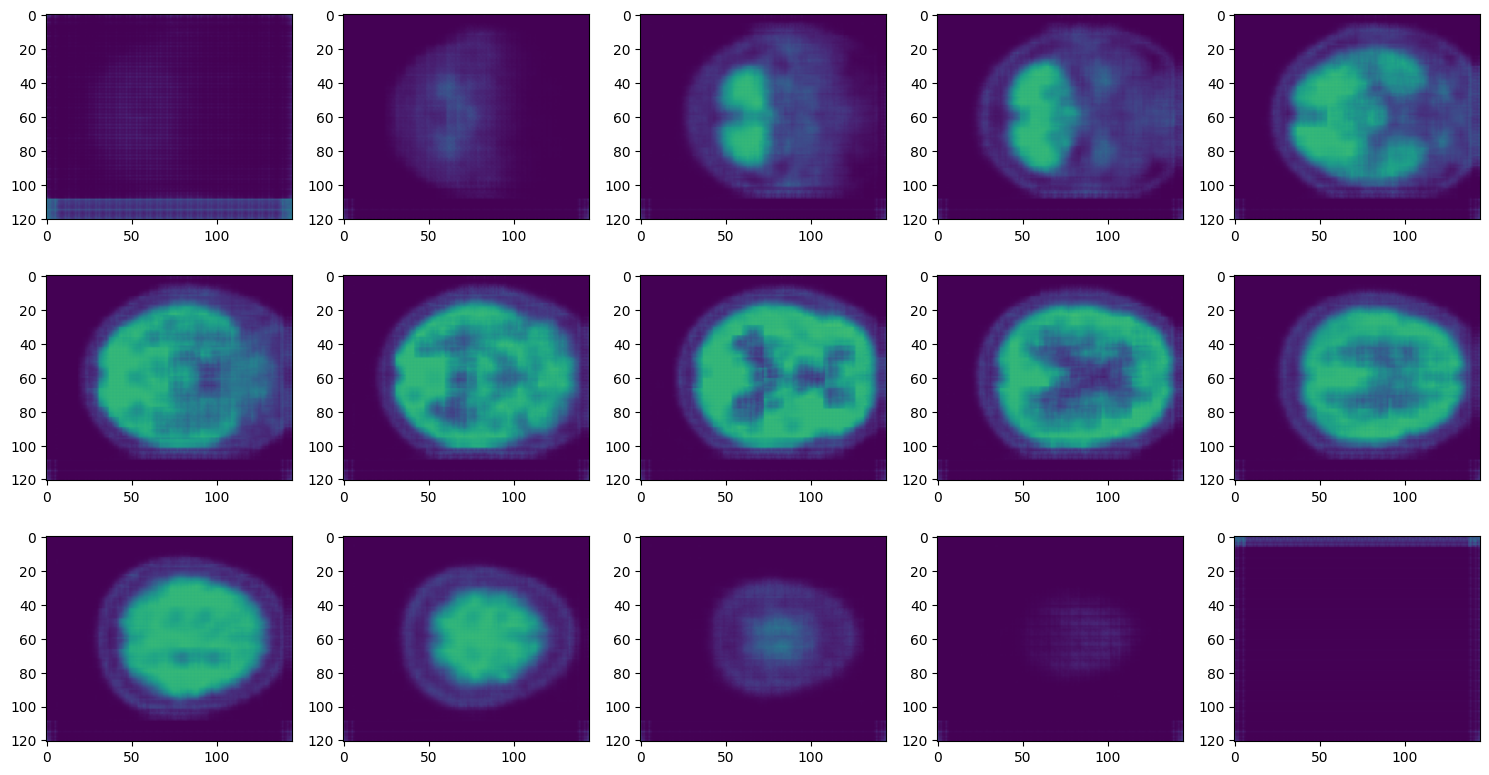

In [45]:
plot_scan(pet_gen.squeeze())

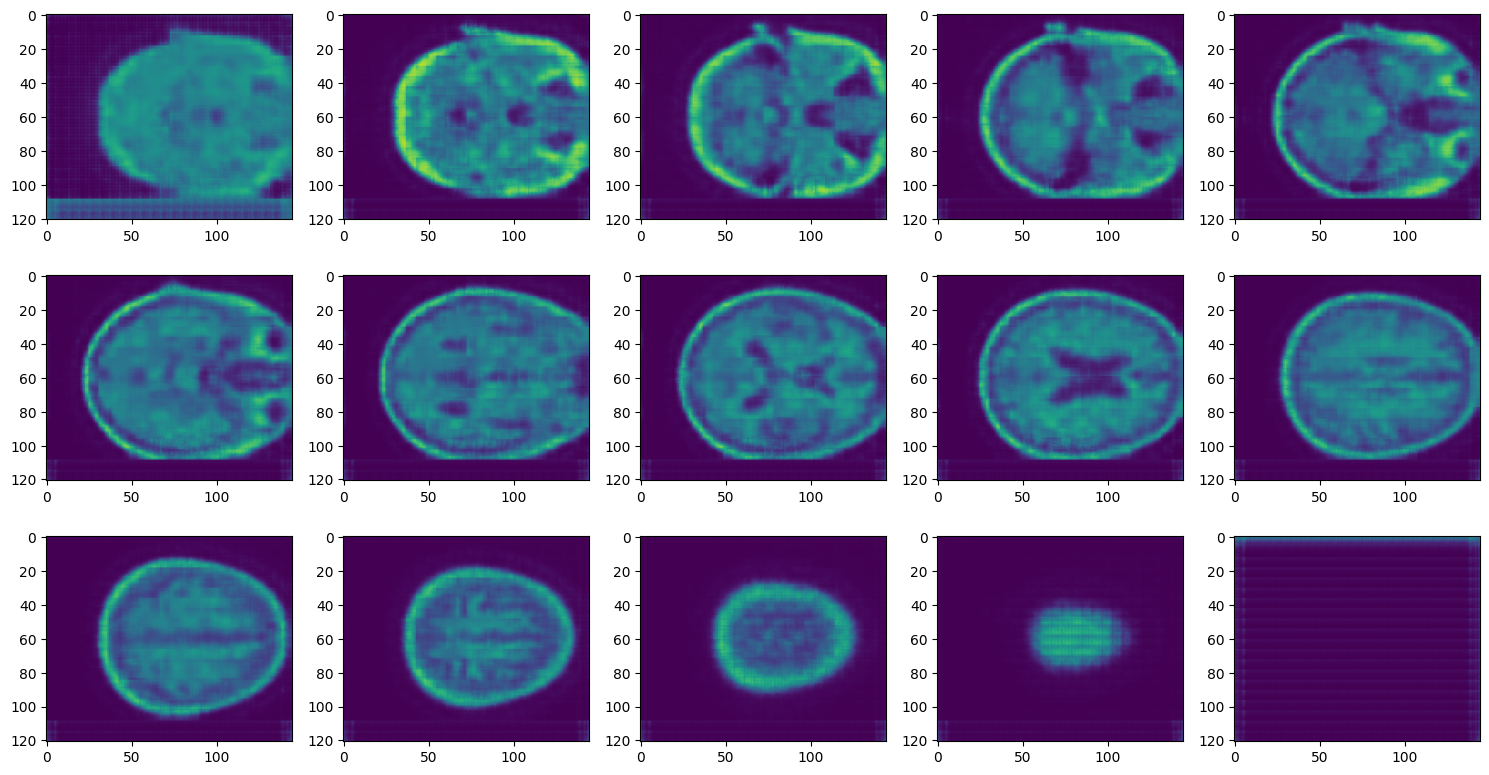

In [48]:
plot_scan(mri_gen.squeeze())

In [38]:
# Cluster using k-means and plot with t-SNE
def plot_tsne(X, clusters):
  '''Cluster the latent representations of the bimodal images'''
  tsne = TSNE()
  points = tsne.fit_transform(X)
  plt.scatter(points[:,0], points[:,1], c=clusters)

In [25]:
all_mu, all_logvar = predict_latent(model, dataset, device=DEVICE)
all_mu = all_mu.cpu()
all_logvar = all_logvar.cpu()

In [61]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(all_mu)

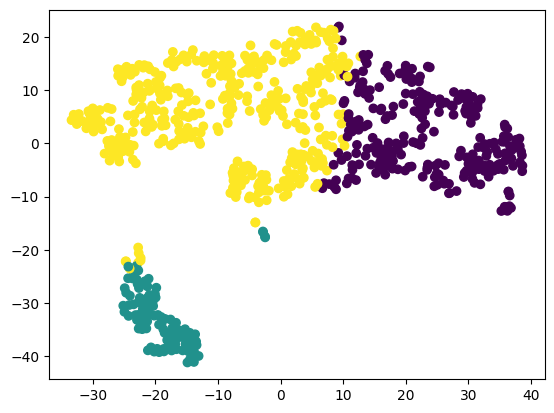

In [62]:
plot_tsne(all_mu, clusters)

In [63]:
# Topo k-means plotting with t-SNE
t_kmeans = topo_kmeans(
    data=all_mu,
    n_knn=30,          # neighborhood size - start with 20-50 imo. Controls how local each persistence diagram is. Too small: diagrams are sparse/uninformative. Too large: neighborhoods blur global structure.
    n_clust=3,         # number of clusters
    sigma=20,          # kernel scale - depends on scaling decision based on data. Larger sigma makes the RBF fall off faster with differences in persistence values.
    power=15,          # power exponent - exagerates distance differences
    null_dim=True,     # sets H0 meaning uses persistence diagram approach
    first_dim=False,   # keep false, if set true it's basically only H1 (loops) but we'd need to compute that, otherwise it's just euclidean
    preserve_ordering=False, # keep false (this is true if we only cared about each point/sample's position in the input order we feed it.)
    dist_matrix=False, # assumes we don't have a dist matrix
    random_state=0,
    random_restarts=200 # rec 20-200 based on R/FCPS implementation version. Start small (say 20) for exploration and then go big say 200, maybe even 1k-5k if compute avail for max fidelity. Would only play around this if sillhoute score/cluster labels etc changing a lot each time
)

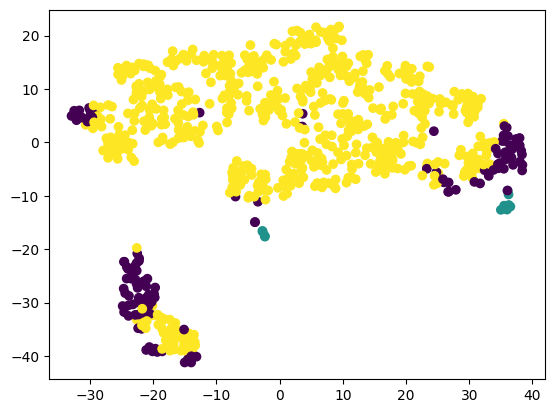

In [64]:
plot_tsne(all_mu, t_kmeans.labels)

In [47]:
all_mu[1]

NameError: name 'all_mu' is not defined